In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0a249e77-677b-9753-8401-39e7c613a9a9)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-12 13:22:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-12 13:22:11 (7.33 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


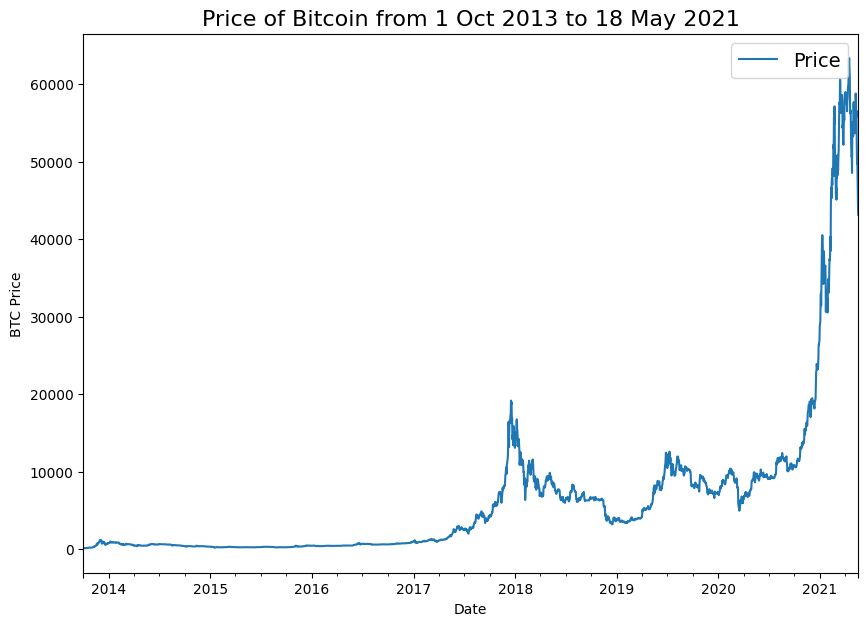

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [7]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

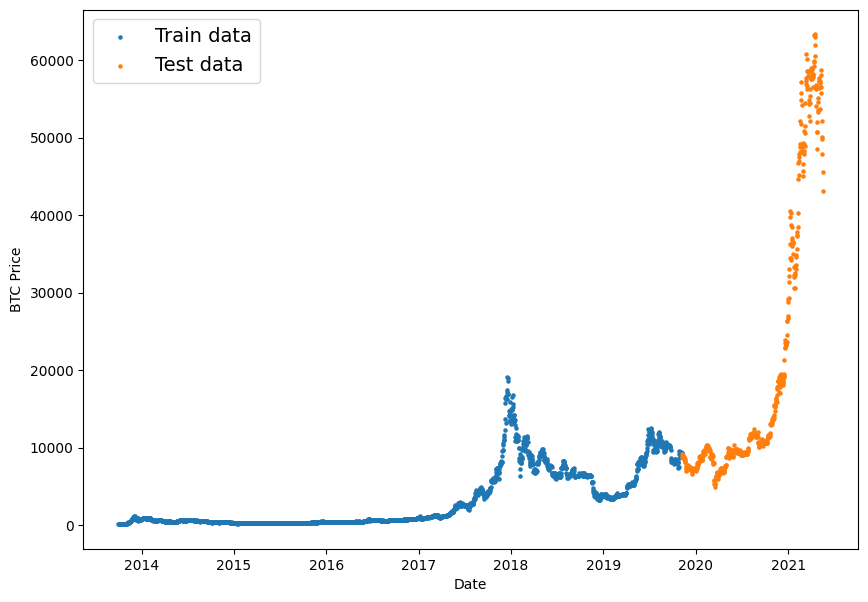

In [11]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [12]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

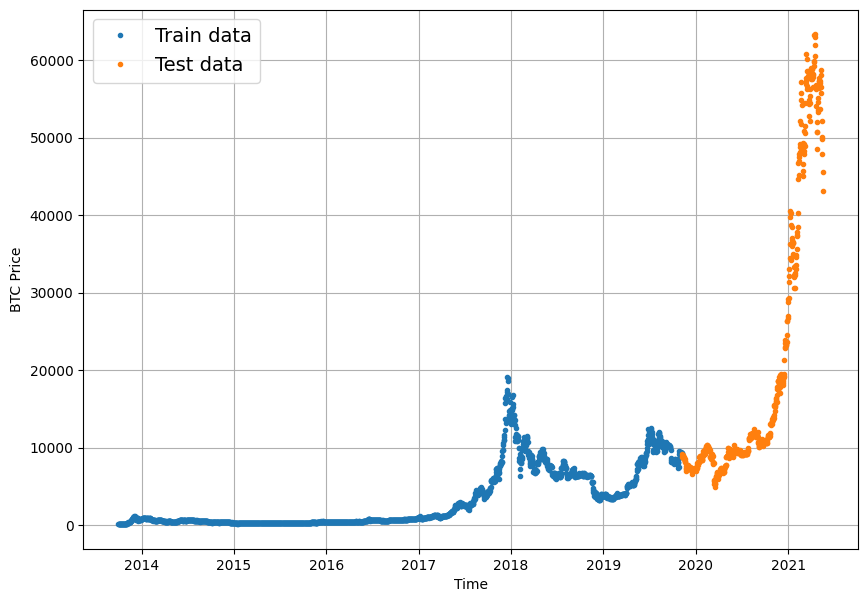

In [13]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Model 0: Naive forecast

In [14]:
naive_forecast = y_test[:-1]

In [15]:
import tensorflow as tf

In [16]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae/mae_naive_no_season

In [17]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [18]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [19]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [20]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [21]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [22]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [23]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [24]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [40]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [41]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [42]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 520.1576 - mae: 520.1576 

18/18 [==============================] - 2s 40ms/step - loss: 502.9432 - mae: 502.9432 - val_loss: 2281.0354 - val_mae: 2281.0354
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 351.5513 - mae: 351.5513

18/18 [==============================] - 1s 30ms/step - loss: 248.7535 - mae: 248.7535 - val_loss: 889.5685 - val_mae: 889.5685
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 175.1632 - mae: 175.1632 - val_loss: 1027.2588 - val_mae: 1027.2588
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 121.9980 - mae: 121.9980

18/18 [==============================] - 1s 30ms/step - loss: 195.5016 - mae: 195.5016 - val_loss: 836.6172 - val_mae: 836.6172
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 150.2736 - mae: 150.2736

18/18 [==============================] - 1s 63ms/step - loss: 164.3503 - mae: 164.3503 - val_loss: 806.2205 - val_mae: 806.2205
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 157.2303 - mae: 157.2303 - val_loss: 833.4487 - val_mae: 833.4487
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 155.4274 - mae: 155.4274 - val_loss: 845.3141 - val_mae: 845.3141
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 152.3861 - mae: 152.3861

18/18 [==============================] - 1s 61ms/step - loss: 152.9122 - mae: 152.9122 - val_loss: 762.2997 - val_mae: 762.2997
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 170.3713 - mae: 170.3713

18/18 [==============================] - 1s 30ms/step - loss: 141.5954 - mae: 141.5954 - val_loss: 756.4352 - val_mae: 756.4352
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 146.7781 - mae: 146.7781 - val_loss: 1103.8516 - val_mae: 1103.8516
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 232.9712 - mae: 232.9712

18/18 [==============================] - 0s 29ms/step - loss: 180.0598 - mae: 180.0598 - val_loss: 733.8168 - val_mae: 733.8168
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 142.8733 - mae: 142.8733 - val_loss: 893.5546 - val_mae: 893.5546
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 154.6148 - mae: 154.6148 - val_loss: 1253.9637 - val_mae: 1253.9637
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 151.4143 - mae: 151.4143 - val_loss: 1020.5914 - val_mae: 1020.5914
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 158.0692 - mae: 158.0692 - val_loss: 814.7985 - val_mae: 814.7985
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 127.9434 - mae: 127.9434

18/18 [==============================] - 1s 55ms/step - loss: 143.8457 - mae: 143.8457 - val_loss: 708.7372 - val_mae: 708.7372
Epoch 17/100
18/18 [==============================] - 0s 10ms/step - loss: 145.2258 - mae: 145.2258 - val_loss: 963.2565 - val_mae: 963.2565
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 153.0264 - mae: 153.0264 - val_loss: 1283.7983 - val_mae: 1283.7983
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 167.4727 - mae: 167.4727

18/18 [==============================] - 1s 43ms/step - loss: 163.0915 - mae: 163.0915 - val_loss: 692.5544 - val_mae: 692.5544
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 151.5642 - mae: 151.5642 - val_loss: 853.8218 - val_mae: 853.8218
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 131.6496 - mae: 131.6496 - val_loss: 1157.6113 - val_mae: 1157.6113
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 181.6586 - mae: 181.6586 - val_loss: 900.6699 - val_mae: 900.6699
Epoch 23/100
15/18 [========================>.....] - ETA: 0s - loss: 149.7684 - mae: 149.7684

18/18 [==============================] - 1s 34ms/step - loss: 146.8718 - mae: 146.8718 - val_loss: 691.7385 - val_mae: 691.7385
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 132.4026 - mae: 132.4026 - val_loss: 712.2039 - val_mae: 712.2039
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 134.6513 - mae: 134.6513

18/18 [==============================] - 1s 30ms/step - loss: 134.2894 - mae: 134.2894 - val_loss: 673.3780 - val_mae: 673.3780
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 127.0753 - mae: 127.0753

18/18 [==============================] - 1s 30ms/step - loss: 127.0753 - mae: 127.0753 - val_loss: 668.7229 - val_mae: 668.7229
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9345 - mae: 123.9345 - val_loss: 700.6575 - val_mae: 700.6575
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 139.5153 - mae: 139.5153 - val_loss: 857.4105 - val_mae: 857.4105
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 141.3159 - mae: 141.3159 - val_loss: 949.0944 - val_mae: 949.0944
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 145.9236 - mae: 145.9236 - val_loss: 1060.3196 - val_mae: 1060.3196
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 138.6668 - mae: 138.6668 - val_loss: 675.9781 - val_mae: 675.9781
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 143.2723 - mae: 143.2723

18/18 [==============================] - 1s 30ms/step - loss: 124.4594 - mae: 124.4594 - val_loss: 656.5121 - val_mae: 656.5121
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 124.2696 - mae: 124.2696 - val_loss: 742.2695 - val_mae: 742.2695
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 135.0268 - mae: 135.0268 - val_loss: 803.3854 - val_mae: 803.3854
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 124.5348 - mae: 124.5348 - val_loss: 680.0928 - val_mae: 680.0928
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 122.2239 - mae: 122.2239 - val_loss: 657.4620 - val_mae: 657.4620
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 130.0524 - mae: 130.0524 - val_loss: 667.2910 - val_mae: 667.2910
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 121.5010 - mae: 121.5010 - val_loss: 704.1450 - val_mae: 704.1450
Epoch 39/100
18/18 [============

18/18 [==============================] - 1s 30ms/step - loss: 131.1583 - mae: 131.1583 - val_loss: 644.6066 - val_mae: 644.6066
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 120.9897 - mae: 120.9897 - val_loss: 708.3538 - val_mae: 708.3538
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 114.4274 - mae: 114.4274

18/18 [==============================] - 1s 30ms/step - loss: 127.1048 - mae: 127.1048 - val_loss: 637.4019 - val_mae: 637.4019
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 94.0134 - mae: 94.0134

18/18 [==============================] - 1s 30ms/step - loss: 118.6835 - mae: 118.6835 - val_loss: 634.6146 - val_mae: 634.6146
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 122.0817 - mae: 122.0817 - val_loss: 949.1624 - val_mae: 949.1624
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 131.4493 - mae: 131.4493 - val_loss: 798.0168 - val_mae: 798.0168
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4584 - mae: 121.4584 - val_loss: 840.4077 - val_mae: 840.4077
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 129.6853 - mae: 129.6853 - val_loss: 655.0127 - val_mae: 655.0127
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 124.5604 - mae: 124.5604 - val_loss: 637.8886 - val_mae: 637.8886
Epoch 49/100
16/18 [=========================>....] - ETA: 0s - loss: 135.9766 - mae: 135.9766

18/18 [==============================] - 1s 32ms/step - loss: 133.7524 - mae: 133.7524 - val_loss: 632.7451 - val_mae: 632.7451
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 125.1636 - mae: 125.1636 - val_loss: 695.5879 - val_mae: 695.5879
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 126.9303 - mae: 126.9303 - val_loss: 865.9268 - val_mae: 865.9268
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 136.4861 - mae: 136.4861 - val_loss: 869.8525 - val_mae: 869.8525
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 156.7529 - mae: 156.7529 - val_loss: 644.6348 - val_mae: 644.6348
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 131.6401 - mae: 131.6401 - val_loss: 793.3158 - val_mae: 793.3158
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 141.4215 - mae: 141.4215 - val_loss: 916.9988 - val_mae: 916.9988
Epoch 56/100
18/18 [============

18/18 [==============================] - 1s 29ms/step - loss: 161.4266 - mae: 161.4266 - val_loss: 630.5699 - val_mae: 630.5699
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 108.8656 - mae: 108.8656

18/18 [==============================] - 1s 30ms/step - loss: 116.1187 - mae: 116.1187 - val_loss: 625.8375 - val_mae: 625.8375
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 123.8361 - mae: 123.8361 - val_loss: 627.9556 - val_mae: 627.9556
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 128.2848 - mae: 128.2848 - val_loss: 773.4547 - val_mae: 773.4547
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 121.9618 - mae: 121.9618 - val_loss: 857.0075 - val_mae: 857.0075
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 122.3860 - mae: 122.3860 - val_loss: 670.3639 - val_mae: 670.3639
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 117.4132 - mae: 117.4132

18/18 [==============================] - 1s 30ms/step - loss: 118.6665 - mae: 118.6665 - val_loss: 618.4179 - val_mae: 618.4179
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 113.8513 - mae: 113.8513 - val_loss: 639.2300 - val_mae: 639.2300
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 119.1058 - mae: 119.1058 - val_loss: 630.7242 - val_mae: 630.7242
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 116.9648 - mae: 116.9648 - val_loss: 763.8232 - val_mae: 763.8232
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 128.9026 - mae: 128.9026 - val_loss: 907.7247 - val_mae: 907.7247
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 130.0099 - mae: 130.0099 - val_loss: 716.3742 - val_mae: 716.3742
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 124.6818 - mae: 124.6818 - val_loss: 1008.0489 - val_mae: 1008.0489
Epoch 72/100
18/18 [==========

18/18 [==============================] - 1s 31ms/step - loss: 121.3563 - mae: 121.3563 - val_loss: 616.1868 - val_mae: 616.1868
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4692 - mae: 116.4692 - val_loss: 619.1912 - val_mae: 619.1912
Epoch 76/100
18/18 [==============================] - 0s 8ms/step - loss: 113.9677 - mae: 113.9677 - val_loss: 737.6091 - val_mae: 737.6091
Epoch 77/100
18/18 [==============================] - 0s 8ms/step - loss: 129.0353 - mae: 129.0353 - val_loss: 717.6451 - val_mae: 717.6451
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 139.0208 - mae: 139.0208 - val_loss: 631.0414 - val_mae: 631.0414
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3389 - mae: 117.3389 - val_loss: 681.3123 - val_mae: 681.3123
Epoch 80/100
18/18 [==============================] - 0s 8ms/step - loss: 114.1838 - mae: 114.1838 - val_loss: 628.9825 - val_mae: 628.9825
Epoch 81/100
18/18 [============

18/18 [==============================] - 1s 43ms/step - loss: 128.4268 - mae: 128.4268 - val_loss: 611.3485 - val_mae: 611.3485
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 115.8412 - mae: 115.8412 - val_loss: 758.6151 - val_mae: 758.6151
Epoch 84/100
14/18 [======================>.......] - ETA: 0s - loss: 121.9111 - mae: 121.9111

18/18 [==============================] - 1s 41ms/step - loss: 121.3037 - mae: 121.3037 - val_loss: 609.4026 - val_mae: 609.4026
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 120.2897 - mae: 120.2897 - val_loss: 1012.7930 - val_mae: 1012.7930
Epoch 86/100
 1/18 [>.............................] - ETA: 0s - loss: 201.5107 - mae: 201.5107

18/18 [==============================] - 1s 46ms/step - loss: 129.8912 - mae: 129.8912 - val_loss: 604.9007 - val_mae: 604.9007
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 128.7211 - mae: 128.7211 - val_loss: 617.5657 - val_mae: 617.5657
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 114.8979 - mae: 114.8979 - val_loss: 622.8356 - val_mae: 622.8356
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 116.5331 - mae: 116.5331 - val_loss: 1323.8387 - val_mae: 1323.8387
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 141.4625 - mae: 141.4625 - val_loss: 697.5810 - val_mae: 697.5810
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 115.8596 - mae: 115.8596 - val_loss: 606.7037 - val_mae: 606.7037
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 119.2129 - mae: 119.2129 - val_loss: 834.7274 - val_mae: 834.7274
Epoch 93/100
18/18 [==========

18/18 [==============================] - 1s 30ms/step - loss: 114.9959 - mae: 114.9959 - val_loss: 604.4754 - val_mae: 604.4754
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5404 - mae: 112.5404 - val_loss: 734.3059 - val_mae: 734.3059
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6511 - mae: 117.6511 - val_loss: 619.5274 - val_mae: 619.5274
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 118.0325 - mae: 118.0325 - val_loss: 621.5269 - val_mae: 621.5269


In [43]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [44]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 604.4754 - mae: 604.4754


[604.4754028320312, 604.4754028320312]

In [45]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8827.592, 8853.016, 8800.217, 8588.648, 8506.668, 8430.971,
        8192.632, 8182.889, 8203.517, 7800.292], dtype=float32)>)

# Model 2

In [28]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [30]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [31]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [32]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 633.4371


633.4371337890625

In [33]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 623.1785


623.1785278320312

In [46]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [47]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 623.1785,
 'mse': 1321234.1,
 'rmse': 1149.4495,
 'mape': 2.834292,
 'mase': 1.0893222}

In [48]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 623.1785,
 'mse': 1321234.1,
 'rmse': 1149.4495,
 'mape': 2.834292,
 'mase': 1.0893222}

# Model 3

In [49]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [50]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [51]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [52]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1345.2511


1345.2510986328125

In [53]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1215.6241


1215.6241455078125

In [54]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [55]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 670.77106 ,  404.11578 ,  318.80106 ,  489.9559  ,  511.8347  ,
         530.4752  ,  545.5894  ,  520.07764 ,  567.96545 ,  630.3076  ,
         849.7989  ,  803.1276  ,  891.65314 ,  912.56586 ,  716.60724 ,
         314.55307 ,  140.96408 ,  195.07639 ,  267.48438 ,  243.38637 ,
         191.02512 ,  210.6511  ,  332.76248 ,  337.82895 ,  203.29744 ,
          94.535576,  138.23264 ,  154.46072 ,  151.92781 ,  217.43945 ,
         310.66064 ,  392.0669  ,  296.0611  ,  377.40533 ,  251.28076 ,
         322.38022 ,  295.25565 ,  250.68555 ,  196.68576 ,  164.85449 ,
         481.20242 ,   79.36119 ,   88.040245,   84.56892 ,  121.625626,
         132.13246 ,   69.94831 ,   96.14928 ,   93.45626 ,  126.705986,
         120.81905 ,  155.83057 ,  249.50279 ,  208.57088 ,  233.23877 ,
         283.81473 ,  518.19727 ,  535.4547  ,  423.09332 ,  581.89    ,
         394.25482 ,  160.85205 ,  211.51416 ,  339.236   ,  347.937   ,
         453.82233 ,  438.9188  ,  500.89615

In [57]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1215.6241,
 'mse': 5286837.5,
 'rmse': 1394.7805,
 'mape': 5.499964,
 'mase': 2.1631348}

# Model 4

In [61]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [62]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [63]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [64]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [65]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [66]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 573.3829


573.3828735351562

In [68]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8864.939, 8771.989, 8961.759, 8753.904, 8740.083, 8714.969,
       8636.642, 8526.595, 8441.387, 8484.598], dtype=float32)>

In [69]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 573.3829,
 'mse': 1181799.4,
 'rmse': 1087.106,
 'mape': 2.5683045,
 'mase': 1.0072749}

# Model 5

In [73]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [75]:
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 3ms/step


In [76]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.4647,
 'mse': 1252377.5,
 'rmse': 1119.0967,
 'mape': 2.6573777,
 'mase': 1.0390397}

In [77]:
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [78]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [79]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


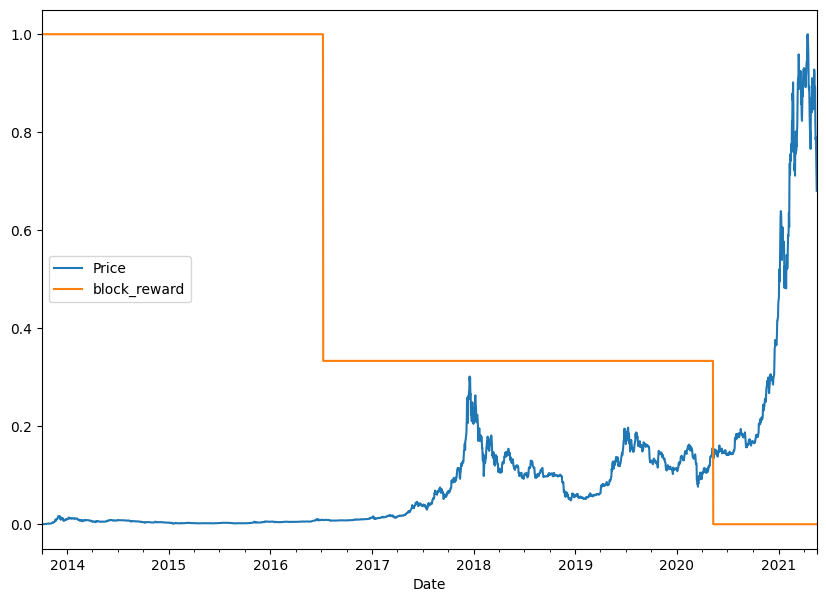

In [80]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [81]:
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods = i+1)

In [84]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [85]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

# Model 6

In [86]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [87]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 6ms/step - loss: 569.6148


569.6148071289062

In [88]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8866.52 , 8796.45 , 9061.354, 8775.892, 8735.178, 8778.102,
       8677.344, 8520.826, 8484.282, 8537.257], dtype=float32)>

In [89]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 569.6148,
 'mse': 1171373.9,
 'rmse': 1082.3003,
 'mape': 2.529275,
 'mase': 1.0006554}

# Model 7

In [92]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [93]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [94]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [95]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [96]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [97]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [99]:
%%time

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = 'InitialBlock'
                                 )

stack_input = layers.Input(shape = (INPUT_SIZE), name = 'stack_input')

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name = f'subtract_00')

for i, _ in enumerate(range(N_STACKS - 1)):
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f'NBeatsBlock_{i}'
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name = f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name = f'add_{i}')

model_7 = tf.keras.Model(inputs = stack_input,
                         outputs = forecast,
                         name = 'model_7_N-BEATS')
model_7.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ['mae', 'mse'])

model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 200, restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 100, verbose = 1)])


Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 277: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 50s, sys: 1.85 s, total: 1min 52s
Wall time: 2min 7s


In [100]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 592.3408 - mae: 592.3408 - mse: 1225575.6250


[592.3407592773438, 592.3407592773438, 1225575.625]

In [101]:
model_7_preds = make_preds(model_7, test_dataset)

1/1 [==============================] - 1s 1s/step


In [102]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 592.34076,
 'mse': 1225575.6,
 'rmse': 1107.0573,
 'mape': 2.6908872,
 'mase': 1.0405786}

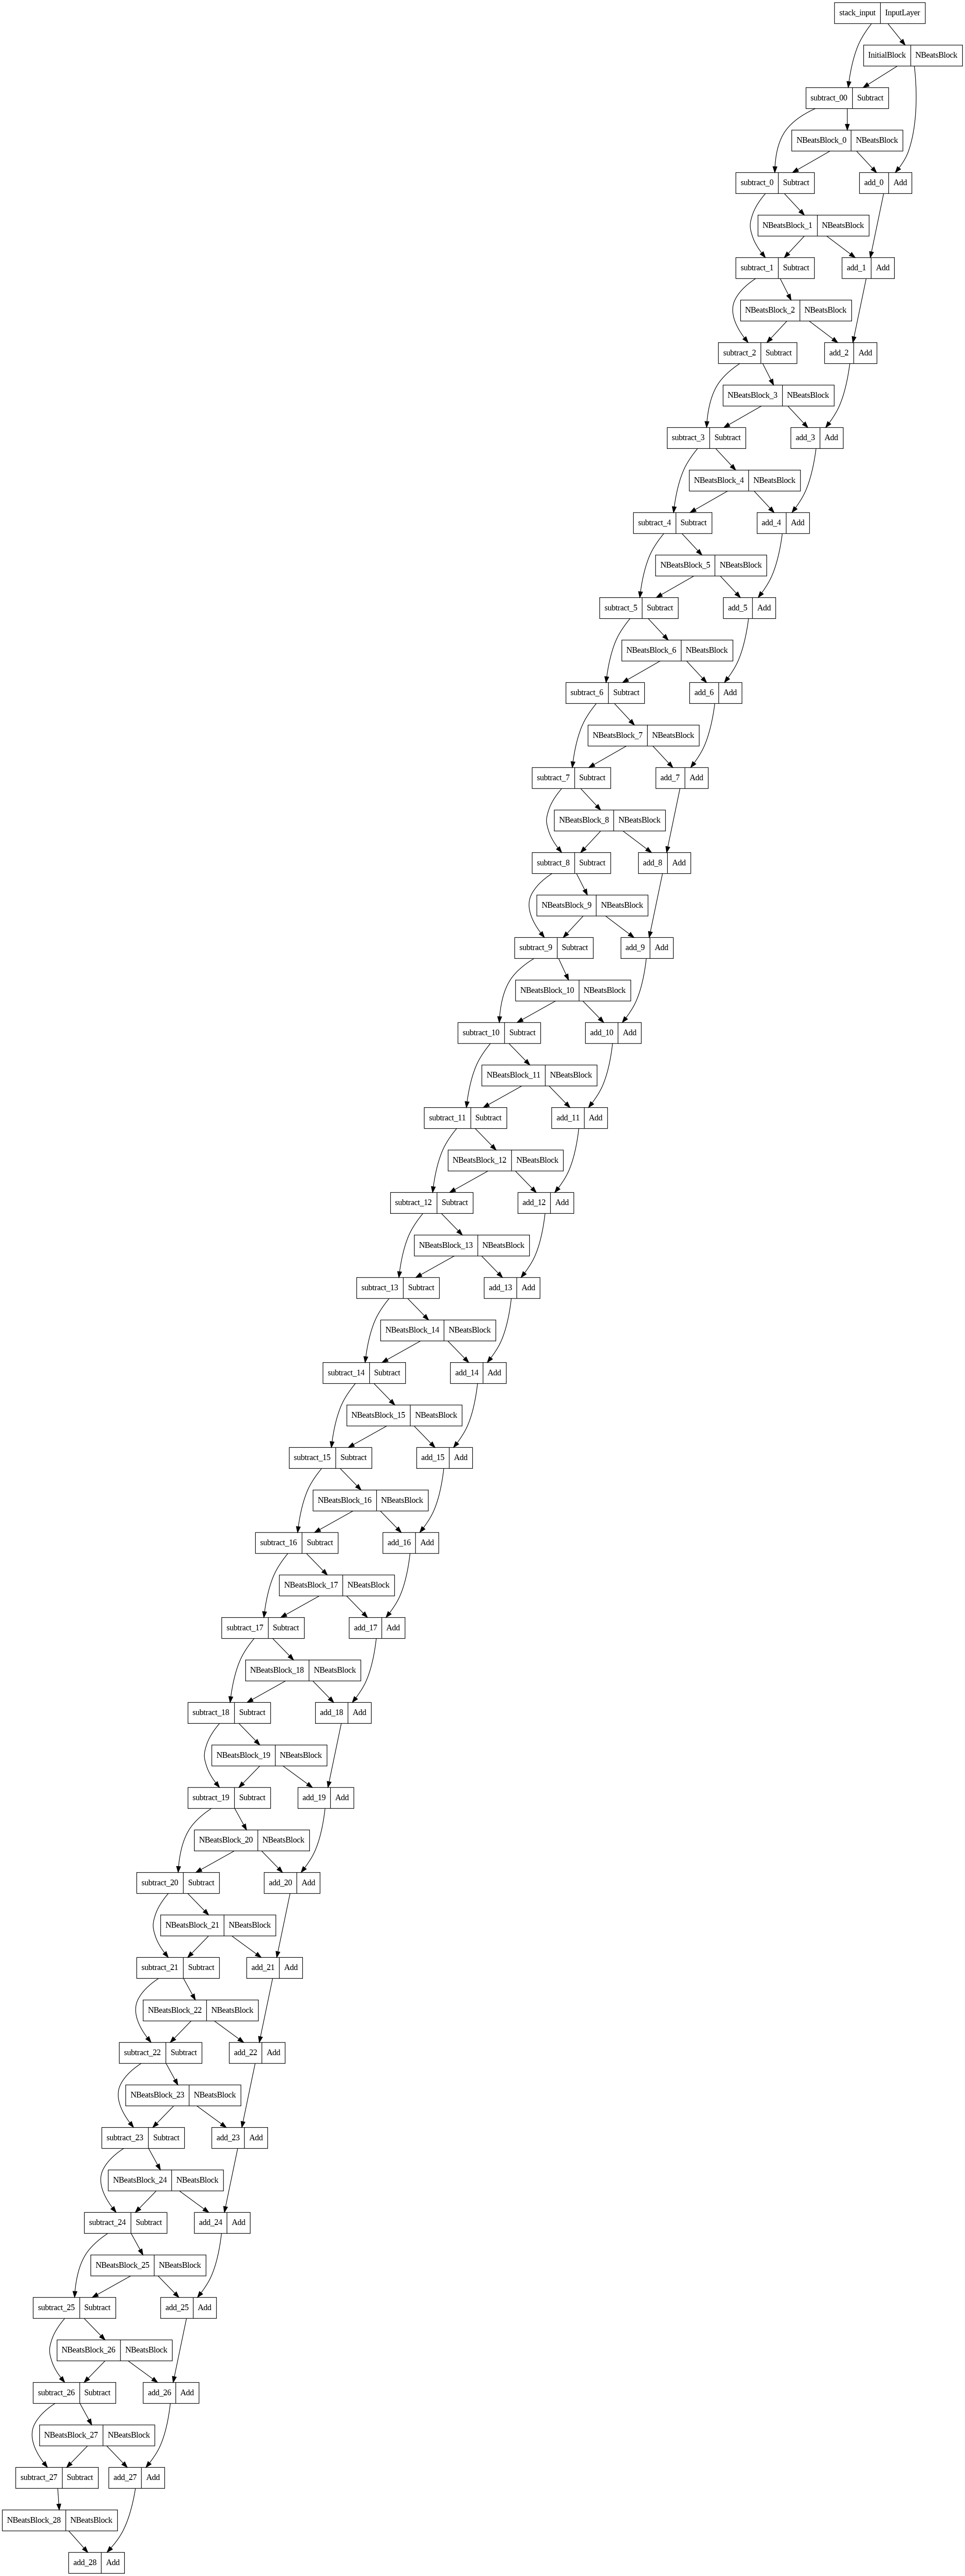

In [103]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

# Model 8

In [105]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=0
                                                                )])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [106]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0
Optimizing model by reducing: mape for 1000 epochs, model number: 0
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1
Optimizing model by reducing: mape for 1000 epochs, model number: 1
Optimizing model by reducing: mae for 1000 epochs, model number: 2
Optimizing model by reducing: mse for 1000 epochs, model number: 2
Optimizing model by reducing: mape for 1000 epochs, model number: 2
Optimizing model by reducing: mae for 1000 epochs, model number: 3
Optimizing model by reducing: mse for 1000 epochs, model number: 3
Optimizing model by reducing: mape for 1000 epochs, model number: 3
Optimizing model by reducing: mae for 1000 epochs, model number: 4
Optimizing model by reducing: mse for 1000 epochs, model number: 4
Optimizing model by reducing: mape for 1000 epochs, model 

In [107]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [108]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8815.414,  8799.94 ,  9045.764, ..., 49287.363, 47961.227,
        45795.977],
       [ 8740.902,  8812.221,  9057.797, ..., 50422.402, 47864.438,
        45847.4  ],
       [ 8844.785,  8772.627,  9005.808, ..., 50197.02 , 48552.96 ,
        46107.766],
       ...,
       [ 8780.703,  8722.658,  9026.535, ..., 49751.734, 48511.5  ,
        46893.633],
       [ 8806.811,  8768.461,  9087.195, ..., 50036.8  , 48173.902,
        46339.137],
       [ 8824.282,  8770.037,  9056.556, ..., 50732.93 , 48292.14 ,
        47549.547]], dtype=float32)>

In [109]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 567.2791,
 'mse': 1135791.4,
 'rmse': 1065.7351,
 'mape': 2.5751233,
 'mase': 0.9965523}